In [124]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [125]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
# os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
# os.environ["xai_api_key"]=os.getenv("X_AI")


In [126]:
from langchain_groq import ChatGroq
from langchain_xai import ChatXAI
from langchain_openai import ChatOpenAI

llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatXAI(model="grok-2")
#llm=ChatOpenAI(model="gpt-4o")

In [127]:
from IPython.display import Image, display

#from langgraph.checkpoint.memory import MemorySaver
#from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph,END
#from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing_extensions import TypedDict
from typing import TypedDict, Dict

In [128]:
#OpenSource llm for code reviewer 
#Grog for reviewer
#llm=ChatGroq(model="qwen-2.5-32b")

In [129]:
from typing import Annotated, List
from pydantic import BaseModel, Field
import operator


# Schema for structured output to use in planning
class AgentTask(BaseModel):
    name: str = Field(
        description="Type of code Agent to perform the code reviews.",
    )
    description: str = Field(
        description="Review the code based on the Agent name.",
    )


class Reviews(BaseModel):
    reviews: List[AgentTask] = Field(
        description="List of review tasks.",
    )

# Augment the LLM with schema for structured output
planner = llm.with_structured_output(Reviews)

In [130]:
class State(TypedDict, total=False):
    objective: str
    code: str
    user_instructions: str
    user_instructions_list: list[str]
    objective_check: str
    agent_tasks: list[AgentTask]
    feedback_Generator: Annotated[
        list, operator.add
    ] 
    feedback_Collector: str
    final_summary: str



In [131]:
def get_user_input(state: State):
    state["objective"] = input("Please enter the Objective of the code to be reviewed: ")
    user_instructions  = input("What types of code reviews do you want the agent to perform? (comma-separated) - (e.g., Syntax, Formatting, Code Quality, Security, Optimization, Best Practices & Design Pattern, etc.): ")
    state["user_instructions"] = [i.strip() for i in user_instructions .split(",")]
    state["code"] = input("Paste your code here: ")
    print(user_instructions)
    return state

In [132]:
def validate_objective(state: State):
    response = llm.invoke(
        f"Verify if code objective matches implementation:\n"
        f"Objective: {state['objective']}\nCode:\n{state['code']}\n"
        "Respond ONLY with 'True' or 'False'"
    )
    state["objective_check"] = response.content.strip().lower() == "true"
    print(state["objective_check"])
    return state

In [133]:
def route_based_on_validation(state: State):
    print(state["objective_check"])
    return "accepted" if state["objective_check"] else "rejected"

In [134]:
# Supervisor Node
# def Master_Reviewer(state: State):
#     """Orchestrator that generates a plan for the reviews to be performed by the agents."""
#     Agent_Tasks = state["Agent_UserInstruction"]
#     return {"Agent_Tasks": {task: "" for task in Agent_Tasks}}

def master_planner(state: State):
    """Orchestrator that generates a plan for the reviews to be performed by the agents."""
    # Generate queries
    result = planner.invoke(
        [
            SystemMessage(content="Plan code review tasks based on user instructions."),
             HumanMessage(content=f"Review types: {state['user_instructions']}")
        ]
    )
    print(result)

    state["agent_tasks"] = result.reviews

    return state

In [135]:
# Worker state
class WorkerState(TypedDict):
    agenttask: AgentTask
    feedback_Generator: Annotated[list, operator.add]

In [152]:
#from langchain_core.runnables import RunnableConfig

def execute_agent_review_task(state: State):
    """Execute all review tasks and store feedback with agent identifiers"""
    agent_feedback = []
    for task in state["agent_tasks"]:
        response = llm.invoke([
            SystemMessage(content=f"You are a {task.name} expert. Perform detailed code review."),
            HumanMessage(content=f"""Task: {task.description}
Code:\n{state['code']}""")
        ])
        agent_feedback.append({
            "agent": task.name,
            "feedback": response.content
        })
    return {"feedback_Generator": agent_feedback}

In [153]:
def synthesize_feedback(state: State):
    """Structure feedback with clear agent attribution"""
    formatted_feedback = []
    for entry in state["feedback_Generator"]:
        formatted_feedback.append(
            f"=== {entry['agent'].upper()} REVIEW ===\n"
            f"{entry['feedback']}\n"
            f"{'-'*40}"
        )
    state["feedback_Collector"] = "\n\n".join(formatted_feedback)
    return state

In [163]:
def generate_summary(state: State):
    """Generate both agent-specific and general summary"""
    if not state["objective_check"]:
        state["final_summary"] = "❌ Objective mismatch between code and stated goals"
        return state
    
    # Generate general summary
    general_summary = llm.invoke(f"""
        Generate final code review summary with this structure:

        1. OVERALL ASSESSMENT
        2. KEY FINDINGS
        3. RECOMMENDATIONS

        Consider this context:
        Objective: {state['objective']}
        Code:\n{state['code']}
        Agent Feedback:\n{state['feedback_Collector']}
    """).content

    # Combine agent feedback with general summary
    state["final_summary"] = (
        "🛠️ AGENT-SPECIFIC FEEDBACK 🛠️\n\n"
        f"{state['feedback_Collector']}\n\n"
        "🔍 GENERAL SUMMARY 🔍\n\n"
        f"{general_summary}"
    )
    return state

In [164]:
# Graph construction
workflow = StateGraph(State)

# Add nodes
workflow.add_node("get_input", get_user_input)
workflow.add_node("validate", validate_objective)
workflow.add_node("plan_tasks", master_planner)
workflow.add_node("synthesize", synthesize_feedback)
workflow.add_node("generate_summary", generate_summary)

# Set up edges
workflow.set_entry_point("get_input")
workflow.add_edge("get_input", "validate")

# Conditional routing
workflow.add_conditional_edges(
    "validate",
    route_based_on_validation,
    {"accepted": "plan_tasks", "rejected": "generate_summary"}
)

# # Dynamic task execution
# def create_task_nodes(state: State):
#     return [{"task": task} for task in state["agent_tasks"]]

workflow.add_node("execute_task", execute_agent_review_task)
workflow.add_edge("plan_tasks", "execute_task")
workflow.add_edge("execute_task", "synthesize")
workflow.add_edge("synthesize", "generate_summary")
workflow.add_edge("generate_summary", END)

# Compile and run
app = workflow.compile()

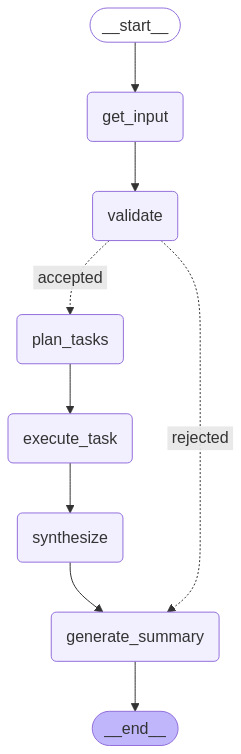

In [165]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [166]:
state = app.invoke({'objective':"", 'code':""})

Syntax,Formating
True
True
reviews=[AgentTask(name='Syntax', description='Check for syntax errors in the code.'), AgentTask(name='Formating', description='Ensure code adheres to style and formatting guidelines.')]


In [167]:
print(state["final_summary"])

🛠️ AGENT-SPECIFIC FEEDBACK 🛠️

=== SYNTAX REVIEW ===
The SQL code provided for creating a table named `users` looks mostly correct, but there are a few syntax and best practice considerations to address:

1. **Comma After Last Column Definition**: In SQL, it's a common mistake to include a comma after the last column definition. Although some database systems tolerate this, others may not. To ensure compatibility, remove the comma after the `created_at` column.
2. **Data Type for `password_hash`**: Using `TEXT` for storing password hashes might be overkill depending on the hash algorithm used (e.g., SHA-256 produces a 64-character string). Consider using `VARCHAR` with a specific length that matches the expected size of the hash.
3. **`CURRENT_TIMESTAMP` Usage**: Using `CURRENT_TIMESTAMP` as a default value is correct, but it is often better to explicitly use `CURRENT_TIMESTAMP` without parentheses unless you are using a specific version of SQL that requires parentheses (like MySQL 5.6